Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».|

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

games = pd.read_csv('/datasets/games.csv')

In [2]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


<span style="color:blue">1. Пропусков много, посмотрим, что они из себя представляют. 2. User_Score надо поменять тип с "object" на "float"</span>

In [3]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

-<big>___critic_score___</big> - оценка критиков - вполне возможно, что игры не оценивались критиками, т.к. тогда этого просто не делали. Было бы неправильно заполнить рейтинг игры средним или медианой, даже если бы мы их считали внутри для каждого жанра отдельно. Тем не менее, чтобы иметь возможность быстрой фильтрации данных и возможность их беспрепятственно обрабатывать, поставим этим играм рейтинг -1, чтобы иметь возможность группировать эти игры по оценке (вдруг у какой-то игры есть нулевой рейтинг, поставив -1, мы никогда не перемешаем игры с NaN и с реально нулевым рейтингом);  
-<big>___rating___</big> - рейтинг от ESRB, согласно Вики была основана в 1994 г. соответственно и рейтинги от нее не могли получить игры, выпущенные ранее. Поставим рейтинг "No ESRB";  
-<big>___user_score___</big> - те же причины, вероятно, ранее не было сервисов, которые собирали бы рейтинги игроков. Поэтому и присутствуют пропуски. Поступим так же, как и со столбцом ___critic_score___.  

Столбец year_of_release (год выпуска игры) имеет 1,6% пропусков. Не много, но неприятно. Средними/медианами эти пропуски не заполнить, эти данные не являются самыми важными для анализа данных, да и пропусков в столбце не так много. Другими словами, целых данных достаточно для анализа, поэтому оставляем как есть.

Ни по одному столбцу заполнить пропуски хотя бы усредненными данными не представляется возможным. Тем не менее, заполним их "нереальными" данными для возможности спокойно работать с этими строками по другим параметрам.

In [4]:
games.columns = games.columns.str.lower()

In [5]:
games.sample(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1282,Resistance 3,PS3,2011.0,Shooter,0.64,0.57,0.05,0.22,83.0,7.8,M
2279,Dynasty Warriors 7,PS3,2011.0,Action,0.25,0.13,0.46,0.06,57.0,7.4,T
9009,Fatal Frame,PS2,2001.0,Action,0.07,0.06,0.00,0.02,74.0,8.9,T
11969,Rugby League 3,Wii,2010.0,Sports,0.00,0.06,0.00,0.01,NaN,NaN,NaN
13585,B's-LOG Party♪,PSP,2010.0,Adventure,0.00,0.00,0.04,0.00,NaN,NaN,NaN


Нужен дополнительный столбец по общим продажам

In [6]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

__Посмотрим пропуски__

Посмотрим игры каких годов имеют пропуски в рейтинге.

In [7]:
games.query('critic_score.isnull() & rating.isnull() & user_score.isnull()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN,0.01


Имеем пропуски в рейтинге игр и старых годов, и в совсем свежих играх.

_Посмотрим, что со столбцом user_score_

In [8]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В списке есть "tbd", простым поиском в Яндексе, узнаем, что это означает To Be Determined, то есть "Будет определено". Ставится, когда игра анонсируется, либо рейтинг не достаточный для подсчета. Т.е. фактически "tbd" нам заменяет "NaN". Поставим вместо него "-1" и поменяем тип столбца на float.

In [9]:
games['user_score'] = games['user_score'].replace('tbd', '-1').fillna(-1).astype('float')

_Теперь очередь столбца critic_score_

In [10]:
games['critic_score'] = games['critic_score'].fillna(-1)

Обработка пропусков в колонках: название игры, год выпуска и жанр.

_Начну с имени. В этой колонке всего 2 имени, поэтому не случится ничего страшного, если мы удалим эти пропуски._

In [11]:
games[games['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,-1.0,-1.0,NaN,2.39
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,-1.0,-1.0,NaN,0.03


In [12]:
games.drop(games[games['name'].isnull()].index , inplace=True)

_Далее идет год выпуска._

In [13]:
def percent_null(column):
    return games[column].isnull().sum()/len(games[column])*100

In [14]:
percent_null('year_of_release')

1.6095255190570215

В колонке "Год выпуска" пропусков немного всего чуть больше 1.5%. Немного, но все равно будем заполнять. Получается, что на некоторых платформах не проставлен год выпуска. У нас чуть больше 250 пропусков, поэтому не случится ничего страшного, если мы заполним пропущенные значения медианой по соседним платформам.

In [15]:
games['year_of_release'] = games['year_of_release'].astype('float64')

In [16]:
for platform in games['platform'].unique():
    median = games.loc[games['platform']==platform, 'year_of_release'].median()
    games.loc[(games['year_of_release'].isna())&(games['platform']==platform), 'year_of_release']=median

In [17]:
games['rating'] = games['rating'].fillna('No ESRB')

Добавим столбец, разъясняющий, что означает каждый рейтинг.

In [18]:
ESRB_dict = {'E': 'Для всех', 'M': '> 17 лет', 'T': '13-19 лет', 'E10+': '>10 лет', 'K-A': 'Устаревший'}
games['ESRB_description'] = games[games['rating'].notnull()]['rating'].map(ESRB_dict)

In [19]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
name                16713 non-null object
platform            16713 non-null object
year_of_release     16713 non-null float64
genre               16713 non-null object
na_sales            16713 non-null float64
eu_sales            16713 non-null float64
jp_sales            16713 non-null float64
other_sales         16713 non-null float64
critic_score        16713 non-null float64
user_score          16713 non-null float64
rating              16713 non-null object
total_sales         16713 non-null float64
ESRB_description    9937 non-null object
dtypes: float64(8), object(5)
memory usage: 1.8+ MB


<span style="color:blue">__Предварительная работа проделана, теперь можно приступать к основному блюду__</span>

_Предполагаю, что графики нам понадобятся часто, поэтому нужно облегчить себе задачу и написать функцию для графики_

In [20]:
def create_graphic(groupby_column, func, y='name'):
    plt.style.use('seaborn-pastel')
    data_to_plot = games.groupby(groupby_column)[y]
    if func == 'count':
        data_to_plot_calculated = data_to_plot.count()
        figsize = (15,5)
        plot = data_to_plot_calculated.plot(kind='bar', y=y, figsize=figsize, ec='black')
    elif func == 'sum':
        data_to_plot_calculated = data_to_plot.sum().sort_values()
        figsize = (15,10)
        plot = data_to_plot_calculated.plot(kind='barh', y=y, figsize=figsize, ec='black')

__Cколько игр выпускалось в разные годы.__

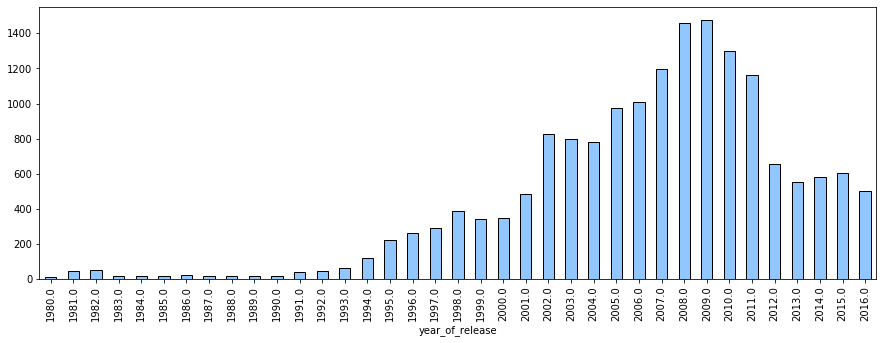

In [21]:
create_graphic('year_of_release', 'count')

По графику видно, что до количество выпускаемых игр до 1995-2000 годов увеличивалось "не спеша" (а до 1994го можно сказать, что и не было), плюс еще и платформа для игр была фактически одна (персональный компьютер). Взрывной рост происходит с 2002г. В это время появляются альтернативные игровые платформы, сравнимые с PC по качеству. Это и PlayStation 2, и Microsoft Xbox, и немного Nintendo GameCube. Пик приходится на 2008-2009 гг. Далее идет спад, поскольку на рынок игр вошли мобильные телефоны, со своими соц сетями. Наблюдается спад интереса к играм. Да и разработчики начинают "гнать брак", хорошие, качественные игры выходят все реже.

Посмотрим на каких платформах чаще всего выпускались игры.

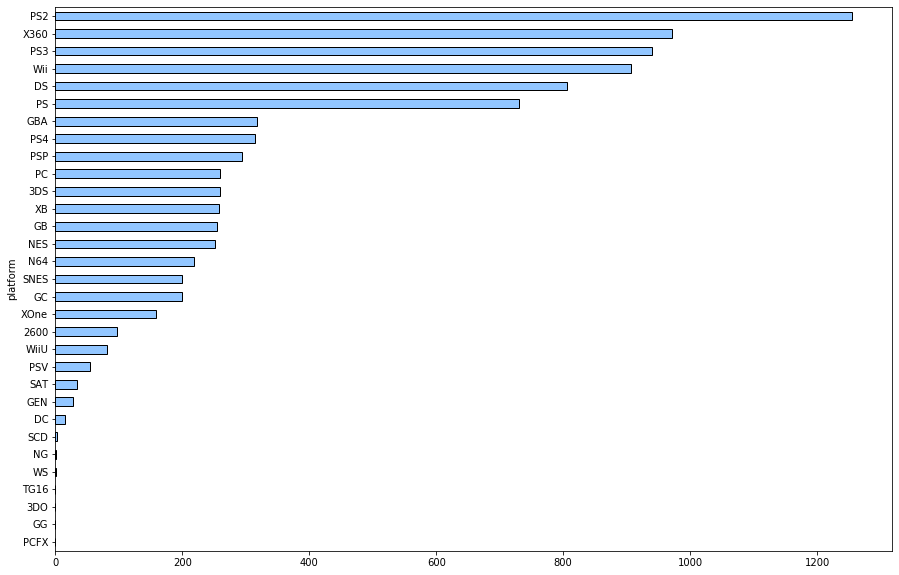

In [22]:
create_graphic('platform', 'sum', 'total_sales')

<span style="color:blue">Итак, самые плодовитые это консоли - PS2, Xbox360, PS3, Wii и т.д.
А самые редкие это раритеты (3DO, GG, PCFX), названия которых многие и не слышали.</span>

In [23]:
total_sales_per_platform = (games
                                .pivot_table(index='platform', values='total_sales', aggfunc='sum')
                                .sort_values('total_sales', ascending=False)
                           )

Выберем 5 платформ с наибольшими продажами.

In [24]:
top5 = total_sales_per_platform.head(5)
top5

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


Продажи на платформах по годам.

In [25]:
def total_sales_by_platform(name, df):
    return (
        df
            .query("platform == @name")
            .pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
            .sort_values('year_of_release', ascending=False)
    )

Нарисуем график продаж по годам.

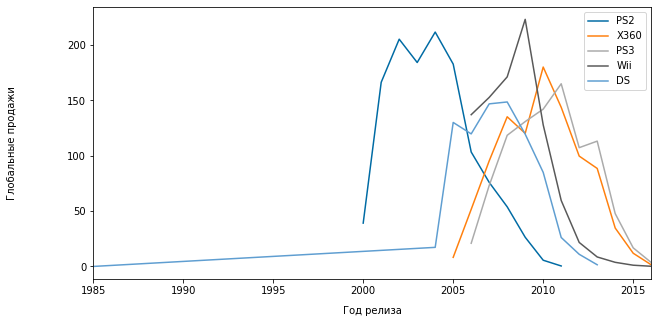

In [26]:
for platform in list(top5.index):
    plt.style.use('tableau-colorblind10') 
    total_sales_by_platform(platform, games)['total_sales'].plot(figsize=(10, 5), label=platform)
    plt.xlabel("Год релиза", labelpad=10)
    plt.ylabel("Глобальные продажи", labelpad=50)
    plt.legend()

<span style="color:blue">В среднем срок жизни игровой платформы 10 лет. Затем производители выпускают следущее поколение.</span>

Выберем период от 2005 года и посмотрим динамику продаж.

In [27]:
actual_years = games['year_of_release'] > 2005
actual_games = games.loc[actual_years]

In [28]:
total_sale = (
               actual_games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
               .sort_values('total_sales', ascending=False)
)

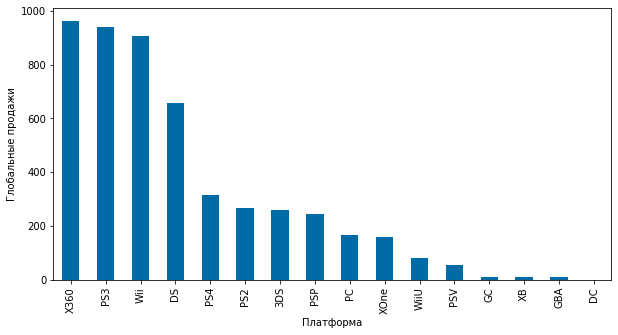

In [29]:
(
   total_sale.plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
   .set(xlabel='Платформа', ylabel='Глобальные продажи')
)
plt.show()

Итак, по продажам у нас лидирует Microsoft со своей платформой Xbox360, далее Sony и ее PlayStation3. Замыкает тройку Wii от Nintendo.

Список платформ за актуальный период. 
И построим графики продаж по каждой платформе.

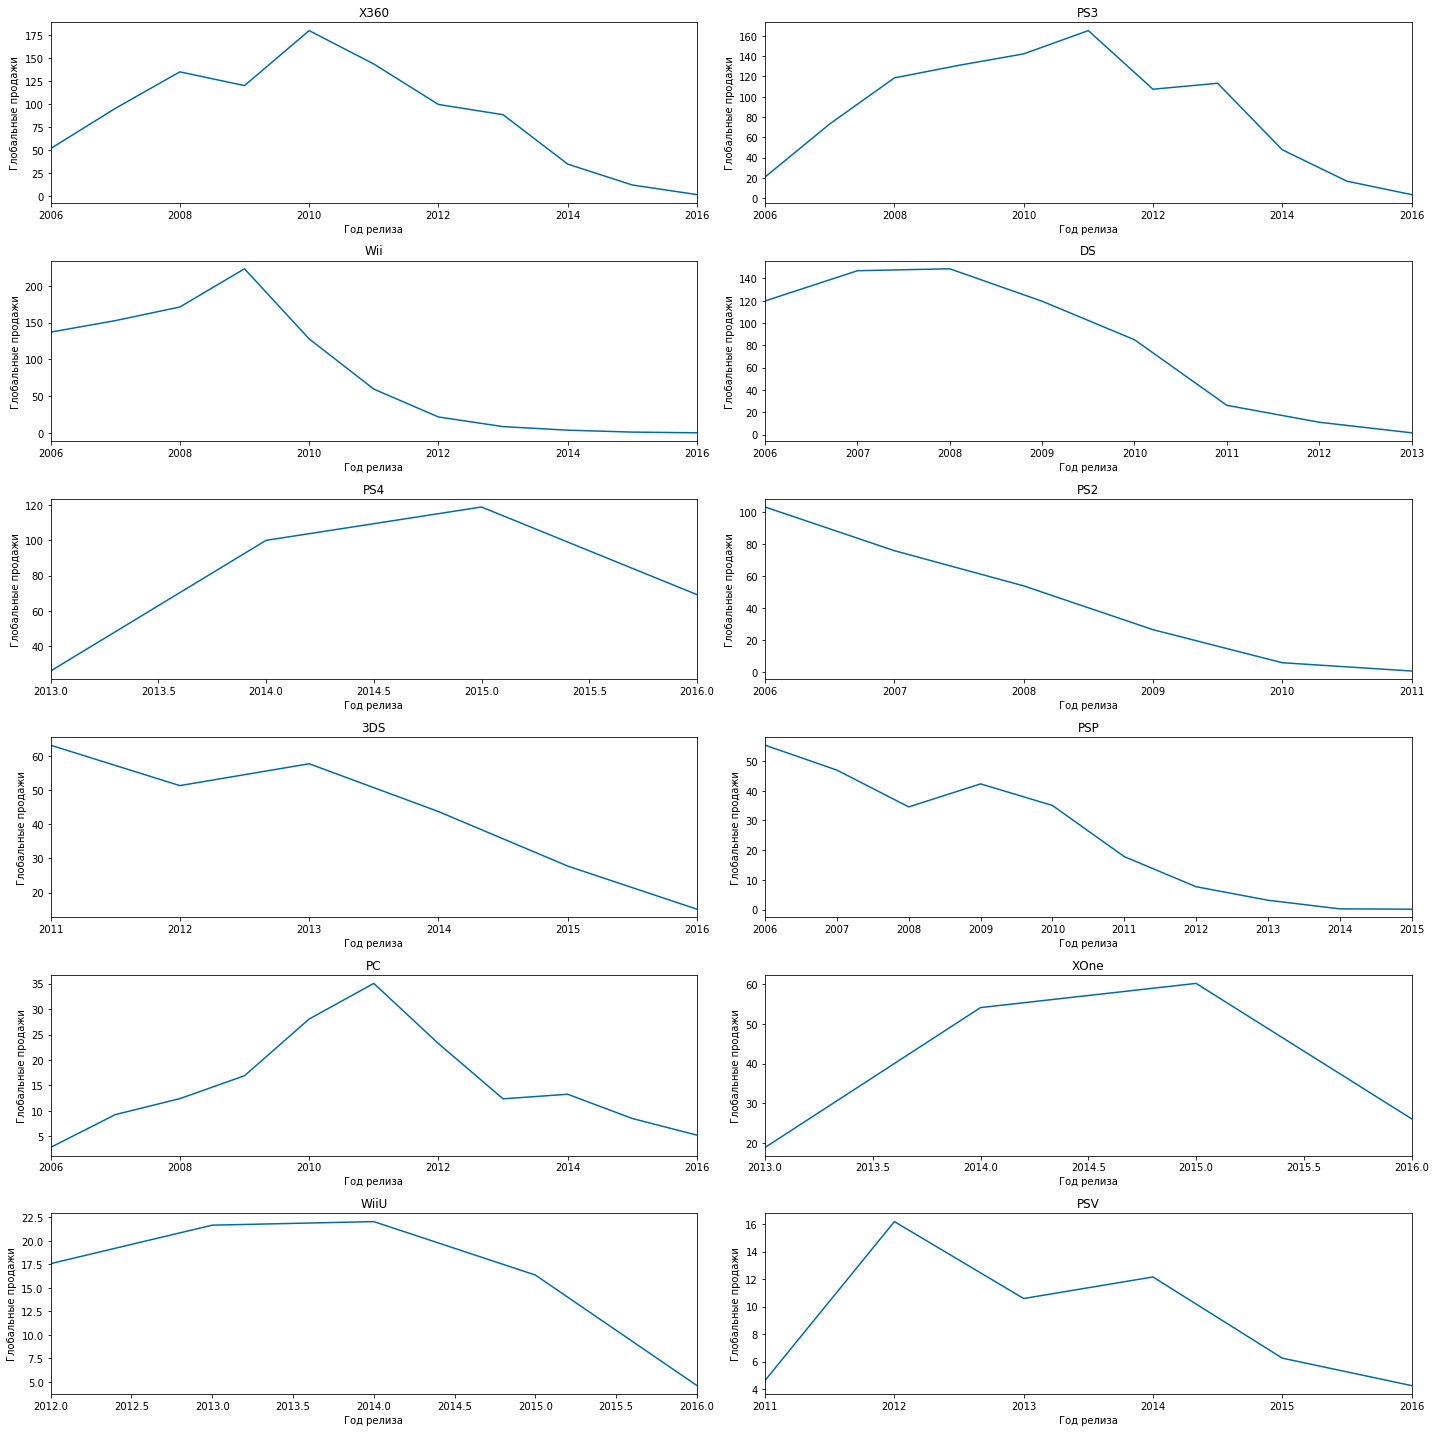

In [30]:
platforms = list(total_sale.index)
rows = 6
cols = (len(platforms) // rows)
fig, ax = plt.subplots(rows, cols)

num = 0
for row in range(rows):
    for col in range(cols):
        plt.style.use('tableau-colorblind10')
        platform = platforms[num]
        (
            total_sales_by_platform(platform, actual_games)['total_sales']
                .plot(ax=ax[row, col], figsize=(20, 20), title=platform)
                .set(xlabel='Год релиза', ylabel='Глобальные продажи')
        )
        num += 1

plt.tight_layout()
plt.show()

Судя по графикам, на всех платформах наблюдается угасание. Еще держатся PS4 и XboxOne, но и у них пдают продажи. Возмжно ситуацию выправят консоли нового поколения, но верится в это слабо.
Посмотрим, что происходит с этими платформами более детально.

__BoxPlot по платформам PlayStation4 и XboxOne__

Среднее значение глобальных продаж игр для PS4: 78.53500000000001
Среднее значение глобальных продаж игр для XOne: 39.83000000000001


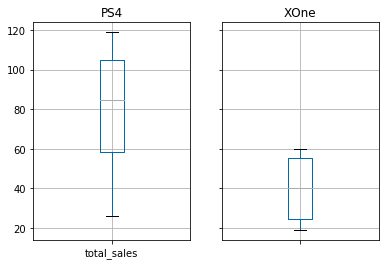

In [31]:
boxplot_platforms = ['PS4', 'XOne']

fig, axs = plt.subplots(1, 2, sharey=True)

for num, platform in enumerate(boxplot_platforms):
    df = total_sales_by_platform(platform, actual_games)
    print("Среднее значение глобальных продаж игр для {}: {}".format(platform, df['total_sales'].mean()))
    df.boxplot('total_sales', ax=axs[num])
    axs[num].set_title(platform)

plt.tick_params(labelcolor='none', bottom='off')
plt.subplots_adjust(left=0.1)
plt.show()

<span style="color:blue"> _Продажи PlayStation4 выше почти в 2 раза, чем продажи XboxOne._ </span>

__Как критика и рейтинги влияют на продажи__

In [32]:
ps4 = actual_games.query("platform == 'PS4'")
xone = actual_games.query("platform == 'XOne'")
feature = ['critic_score', 'user_score' ,'total_sales']

In [33]:
ps4[feature].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.907449,0.226526
user_score,0.907449,1.000000,0.115961
total_sales,0.226526,0.115961,1.000000


In [34]:
xone[feature].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.781040,0.273782
user_score,0.781040,1.000000,0.121712
total_sales,0.273782,0.121712,1.000000


Судя по корреляции ни критика, и отзывы пользователей не сильно влияют на продажи. Хотя на отзывы пользователей сильно влияют критические оценки.
Посмотрим, что будет происходить с диаграммой рассеивания.

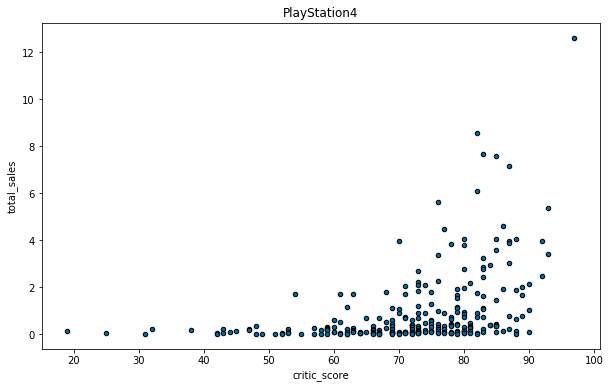

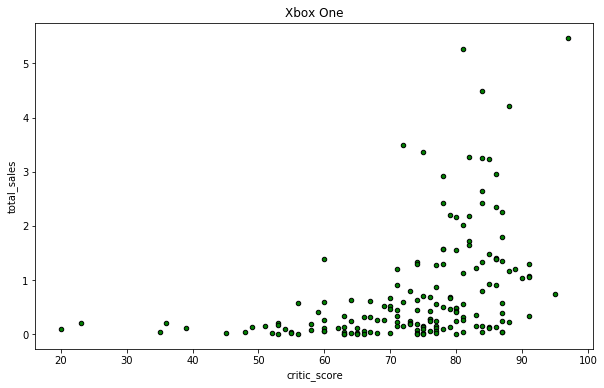

In [35]:
ps4  = games[(games['platform'] == 'PS4') & (games['critic_score'] > 0)]
xone = games[(games['platform'] == 'XOne') & (games['critic_score'] > 0)]
ps4.plot(kind='scatter', x='critic_score', y='total_sales', ec='black', title='PlayStation4', figsize=(10,6))
xone.plot(kind='scatter', x='critic_score', y='total_sales', ec='black', title='Xbox One', figsize=(10,6), color='green')

<span style="color:blue"> С увеличением среднего рейтинга от критиков, увеличивается и средние продажи игр. Ведь, чем качественнее игра, тем лучше к ней отношение.  </span>

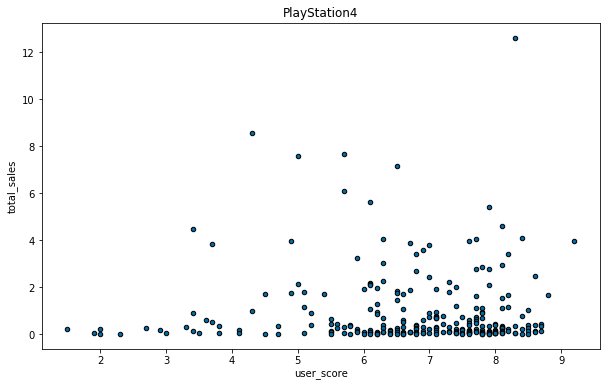

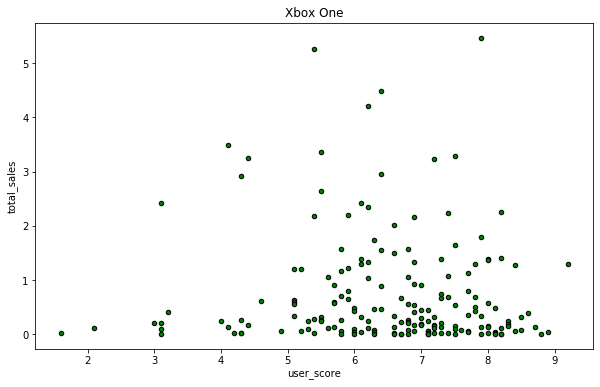

In [36]:
ps4  = games[(games['platform'] == 'PS4') & (games['user_score'] > 0)]
xone = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)]
ps4.plot(kind='scatter', x='user_score', y='total_sales', ec='black', title='PlayStation4', figsize=(10,6))
xone.plot(kind='scatter', x='user_score', y='total_sales', ec='black', title='Xbox One', figsize=(10,6), color='green')

<span style="color:blue"> А вот "брату геймеру" покупатели не так сильно верят, как журналистам профильных изданий. Здесь взаимосвязь между оценкой пользователя и продажей игр очень расплывчатая. </span>

__Посмотрим распределение по жанрам__

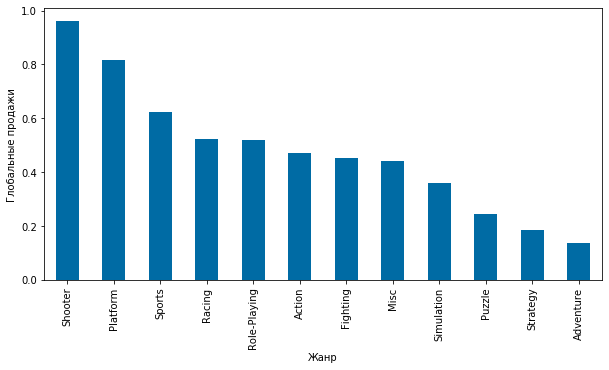

In [37]:
(actual_games
    .pivot_table(index='genre', values='total_sales')
    .sort_values('total_sales', ascending=False)
    .plot(kind='bar', y='total_sales', figsize=(10, 5), legend=False)
    .set(xlabel='Жанр', ylabel='Глобальные продажи'))

plt.show()

<span style="color:blue"> Лидерство у Шутеров и Платформеров. А в аутсайдерах у нас Стратегии и Приключения </span>

__Составим портрет пользователей по регионам__

__North America__

Функция для отрисовки графиков

In [38]:
def sales_regions(groupby, region_sales, ax):
    pivot = games.groupby(groupby).agg({region_sales: 'sum'}).sort_values(by=region_sales, ascending=False)[:5]
    title_dict = {'na_sales': 'North America Sales', 'eu_sales': 'Europe Sales', 'jp_sales': 'Japan Sales'}
    color_dict = {'na_sales': None, 'eu_sales': 'gray', 'jp_sales': 'forestgreen'}
    plot = pivot.plot(kind='bar', ec='black', title=title_dict[region_sales], ax=axes[ax], 
                   fontsize=18, color=color_dict[region_sales], rot=20)
    plot.legend(prop={'size':17})
    plot.set_xlabel('')
    plot.title.set_size(20)

_Самые популярные платформы_

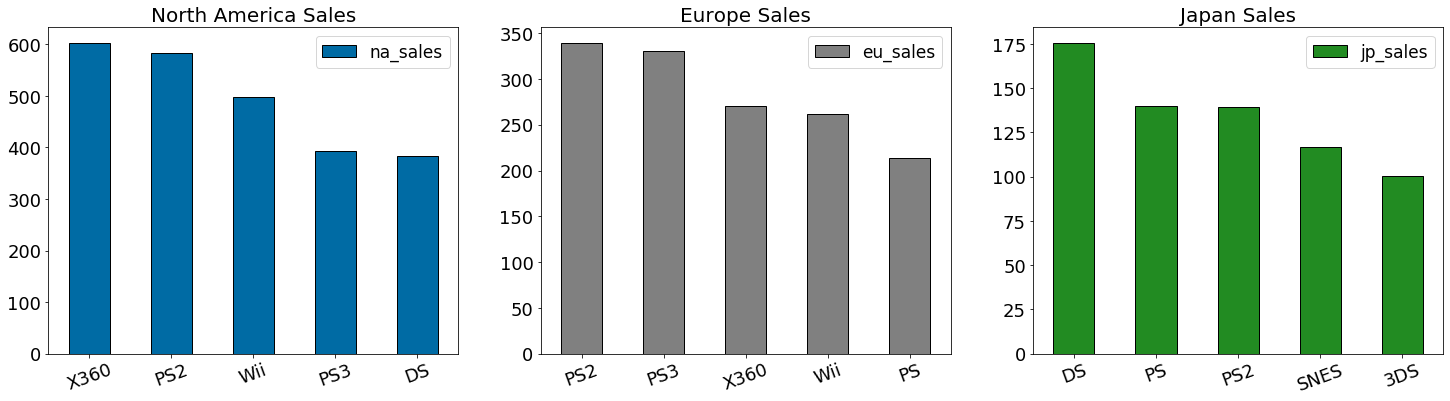

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

sales_regions('platform', 'na_sales', 0)
sales_regions('platform', 'eu_sales', 1)
sales_regions('platform', 'jp_sales', 2)

<span style="color:blue"> В США самая популярная платформа Xbox360, затем PlayStation2. Европу "захватила" Sony, на 3м месте Xbox. А Япония патриотична, никого к себе не пускает, Ds потом PlayStation в топе. </span>

_Самые популярные жанры по регионам._

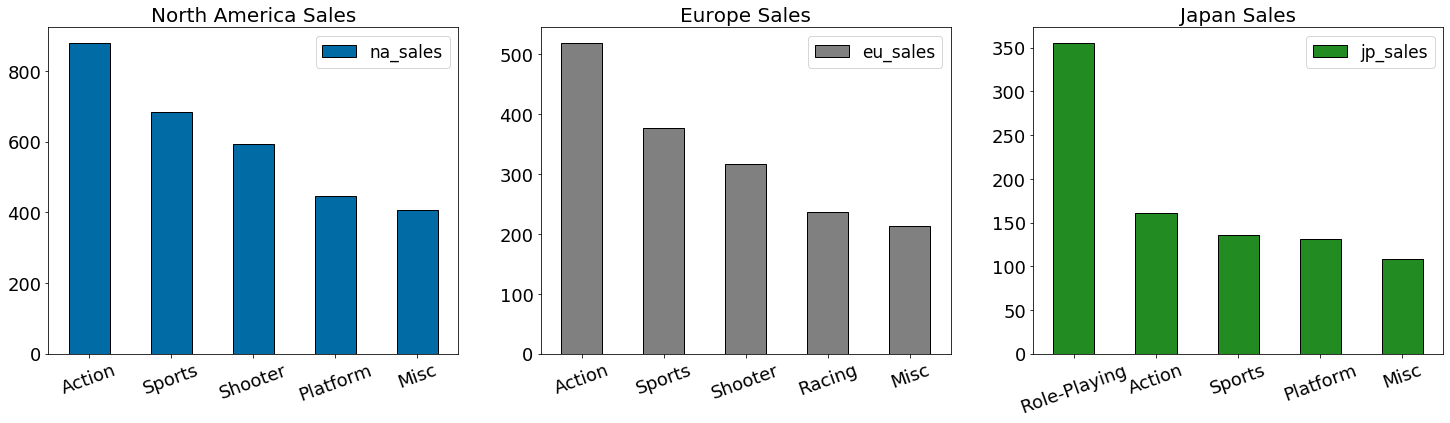

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

sales_regions('genre', 'na_sales', 0)
sales_regions('genre', 'eu_sales', 1)
sales_regions('genre', 'jp_sales', 2)

<span style="color:blue"> Лидирующая тройка в Европе и Северной Америке одинаковая: экшены, спортивные игры и шутеры. В Японии с большим отрывом побеждают ролевые игры, потом экшены и спорт. </span>

_Как влияет рейтинг ESRB на продажи в отдельном регионе._

Добавим нов

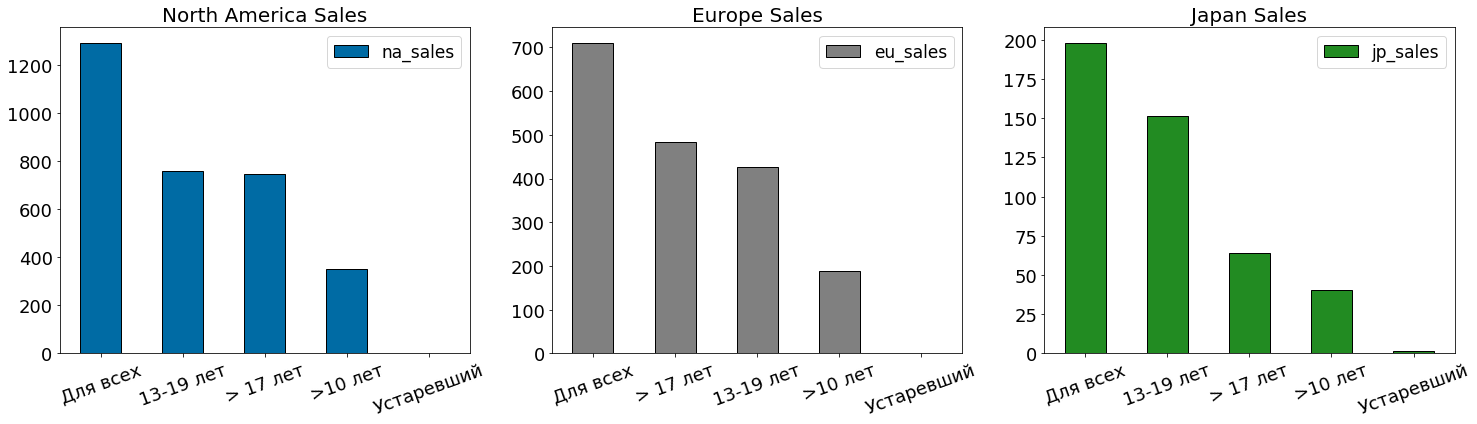

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))

sales_regions('ESRB_description', 'na_sales', 0)
sales_regions('ESRB_description', 'eu_sales', 1)
sales_regions('ESRB_description', 'jp_sales', 2)

<span style="color:blue"> Основной доход во всех регионах приносят игры "для всех", а далее начинаются различия. В Европе и Северной Америке ситуация примерно одинаковая, игры для тинейджеров и для врослых делят 2-3 место. В Японии разрешенные игры для 13-19летс хорошим отрывом заняли 2е место. </span>

__Проверка гипотез__

- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;  
- средние пользовательские рейтинги жанров Action и Sports разные.

__Средние пользовательские рейтинги платформ Xbox One и PC одинаковые__  

Мы рассматриваем две генеральные сопокупности – игры на разных платформах.  

Нулевая гипотеза H₀:  
Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  

Исходя из H₀ формулируем альтернативную гипотезу H₁:  
Средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [42]:
alpha = 0.05

In [43]:
pc = actual_games.query("platform == 'PC'")

results = st.ttest_ind(
    xone['user_score'],
    pc['user_score'],
    equal_var=False,  # Welch’s t-test, который не предполагает равенство дисперсий
    nan_policy='omit' # игнорируем пропуски
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.585723131527127e-15
Отвергаем нулевую гипотезу


<span style="color:blue"> Средние пользовательские рейтинги Xbox One и PC разные. </span>

In [46]:
xbox_one_ratings = games[(games['platform'] == 'XOne') & (games['user_score'] > 0)]['user_score']
pc_ratings = games[(games['platform'] == 'PC') & (games['user_score'] > 0)]['user_score']
print('Средняя оценка пользователей игр для платформы Xbox One  - {:.2f}'.format(xbox_one_ratings.mean()))
print('Средняя оценка пользователей игр для платформы PC - {:.2f}'.format(pc_ratings.mean()))

Средняя оценка пользователей игр для платформы Xbox One  - 6.52
Средняя оценка пользователей игр для платформы PC - 7.06


<span style="color:blue"> Получается, что средняя оценка лучше у PC, чем у Xbox One. Связано с тем, что PC это старая и проверенная платформа. А Microsoft иногда бросает из крайности в крайность, что приводит к тому, что эксклюзивы уходят на сторону. Чаще всего к основному конкуренту. </span>

__Средние пользовательские рейтинги жанров Action и Sports разные__  
Мы рассматриваем две генеральные сопокупности – игры разных жанров.  

Нулевая гипотеза H₀:  
Средние пользовательские рейтинги жанров Action и Sports одинаковые.  

Исходя из H₀ формулируем альтернативную гипотезу H₁:  
Средние пользовательские рейтинги жанров Action и Sports различаются.  

In [47]:
action = actual_games.query("genre == 'Action'")
sports = actual_games.query("genre == 'Sports'")

results = st.ttest_ind(
    action['user_score'],
    sports['user_score'],
    nan_policy='omit' # игнорируем пропуски
)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0017995420307000084
Отвергаем нулевую гипотезу


Вероятность того, что рейтинги будут одинаковыми очень маленькая, и случайно это не может произойти. Соответственно, нулевая гипотеза не подтвердилась.

<big>__Общий вывод__</big>

Что мы в итоге можем сказать. На продажи игр оценки критиков оказыват влияние большее, нежели отзывы пользователей. Так, что если игроделы хотят получить прибыль, пусть вкладываются в рекламу и заказывают хвалебные статьи :)

В целом про положение дел в игровой индустрии: рынок "немобильных" игр постепенно погибает. Большинство сейчас "сидит" в телефоне. Это так удобно: посмотрел соцсети, поиграл в "мобилу". Не надо таскать с собой громоздкий ящик с монитором (телевизором), чтобы поиграть. Заставить пользователя "зависнуть" дома около компьютера или телевизора с приставкой может только красивая, технологичная игра, над которой, к тому же, не надо много думать.

В итоге, гиганты игровой индустрии гоняются за технологиями, а более мелкие компании, не имеющие таких бюджетов, вынуждены отступать, т.к. единственный их козырь - способность создать глубокую игру с атмосферной - ценится только немногочисленными адептами Old School.
Всё это привело к тому, что рынок уже который год падает. И, скорее всего, будет падать. Потому что мобильные платформы тоже развиваются и по мощности уже сравнимы со средними компьютерами и приставками.